<h1 >Dimer Prediction using Bi-LSTM </h1>


load packages

In [1]:
import pandas as pd
import numpy as np

from sklearn import model_selection
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, Bidirectional
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

<h2>1. Data Preparation</h2>

PrimerROC data with 319 pairs and binary label for dimer (dimer formation if 1, otherwise 0)

In [2]:
example_pd = pd.read_csv("example_pd.csv")
example_pd

,primer1,primer2,label
0,AGCATTGTGGGTAGTAAGGTATAAA,AGCTCAAAATCTACATAACCCCTC,0
1,AGCGTGGTTATTGGATGGGTTTG,AGCAAATCTTTACTAAAAAAAATTTACCTT,0
2,AGCGGTAAGTGTTTAGGATGGTT,AGCATCACAAAACCCCTCCCTT,0
3,AGCCCCAAAACACCCCCACT,AGCGGGTTAAAGAGAAGAAGGTT,0
4,AGCAAACTATCCAATCAAACACACA,AGCGAGGATATAGAGTAGTGAAG,0
...,...,...,...
314,AGCTTAAAAATGGGGTGGGGTAG,AGCCCAATATAAATCCCCACCC,1
315,GACCTCAACGCACAGTACGATTTCCAACCCAATTTTCCAAC,CGTCACTGAAACCACCGGAATAAATGTTTTGGAGAGTTTAAGTG,1
316,AGCACCAATATAAATCCCCACCC,AGCAAAAATGGGGTGGGGTAGG,1
317,GACCTCAACGCACAGTACGATGATTAATAAGTGTTTTTTGTTGTG,CGTCACTGAAACCACCGGAACTCAACTTACCACAATAAACC,1


In [3]:
example_pd["label"].value_counts()

0    267
1     52
Name: label, dtype: int64

over-sampling

In [4]:
from imblearn.over_sampling import RandomOverSampler
X = example_pd[["primer1", "primer2"]]
y = example_pd["label"]
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_resample(X, y)

In [5]:
X

,primer1,primer2
0,AGCATTGTGGGTAGTAAGGTATAAA,AGCTCAAAATCTACATAACCCCTC
1,AGCGTGGTTATTGGATGGGTTTG,AGCAAATCTTTACTAAAAAAAATTTACCTT
2,AGCGGTAAGTGTTTAGGATGGTT,AGCATCACAAAACCCCTCCCTT
3,AGCCCCAAAACACCCCCACT,AGCGGGTTAAAGAGAAGAAGGTT
4,AGCAAACTATCCAATCAAACACACA,AGCGAGGATATAGAGTAGTGAAG
...,...,...
529,AGCCTAAACTTTTTAACCCTTTCCT,AGCTTTTGAGTGAAGGAAGGGAA
530,GACCTCAACGCACAGTACGAATACTTCTTAAAAAAATAACCTTCT,CGTCACTGAAACCACCGGAAAAGAAAATAGGTTTTTGGTTTTAAA
531,GACCTCAACGCACAGTACGAATTAGGTAGAGGTGGGTGG,CGTCACTGAAACCACCGGAAAAAAAAACAATCCCTTTCCCTA
532,GTCATGCGCCCCATAATTTGTTTTTGTAATTGTTTTAGTAAA,CTCGGACGCACCCATCTAATATCTTCACATATCAATATAT


In [6]:
y.value_counts()

0    267
1    267
Name: label, dtype: int64

In [7]:
example_pd_temp = pd.DataFrame()
example_pd_temp[["primer1", "primer2"]] = X

integer encoding for sequences

In [8]:

nucleotide = {}
nucleotide["A"] = 0
nucleotide["C"] = 1
nucleotide["G"] = 2
nucleotide["T"] = 3

X1 = [[nucleotide[s] for s in x] for x in example_pd_temp["primer1"]]
X2 = [[nucleotide[s] for s in x] for x in example_pd_temp["primer2"]]


truncate and pad input sequences

In [9]:
max_length= 50
X1 = sequence.pad_sequences(X1, maxlen=max_length)
X2 = sequence.pad_sequences(X2, maxlen=max_length)

binary response variable

In [10]:
y = y.values

<h2>2. Model</h2>

define model

In [11]:

def Bi_LSTM():
    num_nt = 4
    # create the model
    embedding_vecor_length = 32
    inp1 = Input(shape=(max_length,))  
    x1 = Embedding(num_nt, embedding_vecor_length, input_length=max_length)(inp1)
    x1 = Bidirectional(LSTM(100))(x1)

    inp2 = Input(shape=(max_length,))  
    x2 = Embedding(num_nt, embedding_vecor_length, input_length=max_length)(inp2)
    x2 = Bidirectional(LSTM(100))(x2)

    x = Concatenate()([x1, x2])

    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs = [inp1, inp2], outputs = x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model


initialize the model

In [12]:
model = Bi_LSTM()

fit model with early stopping, the same to the train and val data

In [13]:
es = EarlyStopping(monitor="val_acc", min_delta=0, patience=10,restore_best_weights=True)

history = model.fit([X1, X2], y, epochs=100, batch_size=32, validation_data = ([X1, X2], y), callbacks=[es])

Epoch 1/100
17/17 [==============================] - 14s 355ms/step - loss: 0.6911 - acc: 0.5018 - val_loss: 0.6357 - val_acc: 0.7603
Epoch 2/100
17/17 [==============================] - 2s 134ms/step - loss: 0.6112 - acc: 0.6889 - val_loss: 0.5481 - val_acc: 0.7322
Epoch 3/100
17/17 [==============================] - 2s 111ms/step - loss: 0.5466 - acc: 0.7475 - val_loss: 0.5660 - val_acc: 0.7547
Epoch 4/100
17/17 [==============================] - 2s 110ms/step - loss: 0.5483 - acc: 0.7644 - val_loss: 0.5539 - val_acc: 0.7434
Epoch 5/100
17/17 [==============================] - 2s 110ms/step - loss: 0.5573 - acc: 0.7402 - val_loss: 0.5604 - val_acc: 0.7509
Epoch 6/100
17/17 [==============================] - 2s 116ms/step - loss: 0.5617 - acc: 0.7374 - val_loss: 0.5499 - val_acc: 0.7453
Epoch 7/100
17/17 [==============================] - 2s 108ms/step - loss: 0.5376 - acc: 0.7439 - val_loss: 0.5486 - val_acc: 0.7566
Epoch 8/100
17/17 [==============================] - 2s 109ms/step -

confusion matrix

In [14]:
y_hat = model.predict([X1, X2])
y_hat = y_hat > 0.5
confusion_matrix(y, y_hat)

array([[189,  78],
       [ 50, 217]], dtype=int64)

model architecture

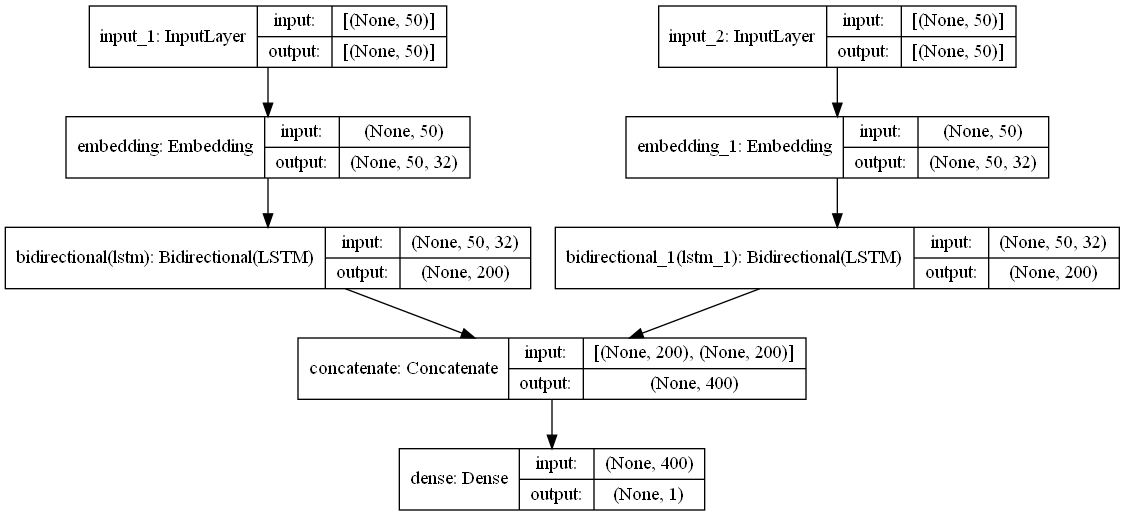

In [15]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

from keras.utils.vis_utils import plot_model    
plot_model(model, show_shapes=True, show_layer_names=True)

<h2>3. Validation</h2>

repeated k-fold cross validation

In [16]:
epochs = 100  # maximum number of training epochs
folds = 10  # the number of folds for k-fold cross validation
n_repeats = 5  # the number of repeats for repeated k-fold cross validation

stratified_folds = model_selection.RepeatedStratifiedKFold(n_splits=folds, n_repeats=n_repeats).split(y, y)

for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
    train_X1, test_X1 = X1[train_index], X1[test_index]
    train_X2, test_X2 = X2[train_index], X2[test_index]
    train_y, test_y = y[train_index], y[test_index]
    
    model = Bi_LSTM()
    
    history = model.fit([train_X1, train_X2], train_y, epochs=epochs, validation_data=([test_X1, test_X2], test_y), verbose=0, callbacks=[es])
    
# calculate performance on the test data and return along with history
test_accs = history.history["val_acc"]

Training and evaluating on fold 1 out of 50...
Training and evaluating on fold 2 out of 50...
Training and evaluating on fold 3 out of 50...
Training and evaluating on fold 4 out of 50...
Training and evaluating on fold 5 out of 50...
Training and evaluating on fold 6 out of 50...
Training and evaluating on fold 7 out of 50...
Training and evaluating on fold 8 out of 50...
Training and evaluating on fold 9 out of 50...
Training and evaluating on fold 10 out of 50...
Training and evaluating on fold 11 out of 50...
Training and evaluating on fold 12 out of 50...
Training and evaluating on fold 13 out of 50...
Training and evaluating on fold 14 out of 50...
Training and evaluating on fold 15 out of 50...
Training and evaluating on fold 16 out of 50...
Training and evaluating on fold 17 out of 50...
Training and evaluating on fold 18 out of 50...
Training and evaluating on fold 19 out of 50...
Training and evaluating on fold 20 out of 50...
Training and evaluating on fold 21 out of 50...
T

overall accuracy

In [17]:
print(f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%")

Accuracy over all folds mean: 74.7% and std: 2.2%


distribution of accuracy

Text(0, 0.5, 'Count')

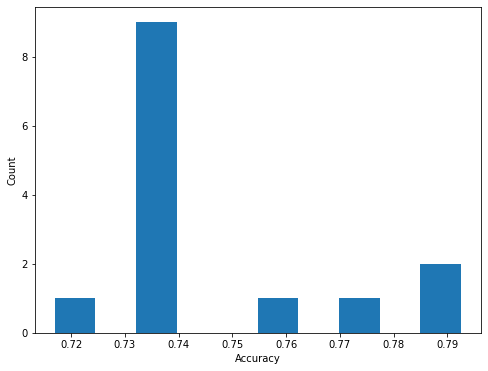

In [18]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")